In [83]:

!apt updateapt update
!pip install mdbtools-dev
!apt-get install mdbtools
!pip install pandas pyodbc
!pip install pymssql
!pip install tempfile2
!pip install japanize-matplotlib
import warnings
warnings.filterwarnings('ignore')

E: Invalid operation updateapt
ERROR: Could not find a version that satisfies the requirement mdbtools-dev (from versions: none)
ERROR: No matching distribution found for mdbtools-dev
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mdbtools is already the newest version (1.0.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=ea1b5925b2caa817c51a70908ad224d0f9bcbb7dd2806410ddcda5ed25090256
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
import sys
sys.path.append('/content/drive/MyDrive/Dev/py2/')
import numpy as np

import pandas as pd
from google.colab import files
import os
import subprocess
from io import StringIO  # StringIOを正しくインポート
import model.utility.k_analysis_util as k_a_util
import model.utility.k_analysis_util as k_analysis_util
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [86]:
def query_re_records_by_y(y):
  db_path = f"/content/drive/MyDrive/Dev/Kjvan/kjdb_prediction_cache_{y}.accdb"
  cmd = """select * from HorseResult
  """
 # where rr_r_id='{program_id}' and rr_r_race='{race_no}
  return k_analysis_util.execute_mdb_sql(db_path, cmd)


In [87]:
db_path = "/content/drive/MyDrive/Dev/Kjvan/kjdb_predict_result.accdb"
today = datetime.datetime.now()

In [88]:
sort_key ='pr_rank'
#sort_key ='pr_hE_pred'
ascending=False
cmd = f"select * from PredictResults"
df_pr = k_analysis_util.execute_mdb_sql(db_path, cmd)

Query output saved to: /tmp/tmprguzb8x0.txt


In [89]:
# まず'pr_program_id'を文字列型に変換
df_pr['pr_program_id'] = df_pr['pr_program_id'].astype(str)

# その後、文字列抽出と数値変換を実行
df_pr = df_pr[df_pr['pr_program_id'].str[4:6].astype(int) >= today.month]
#df_pr=df_filtered

Query output saved to: /tmp/tmpbc50hzxh.txt


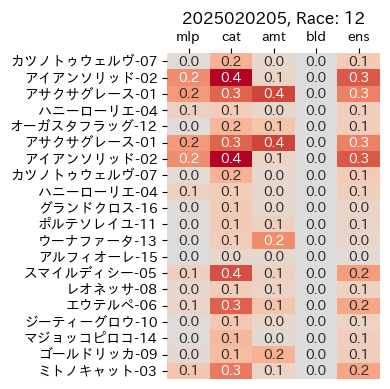

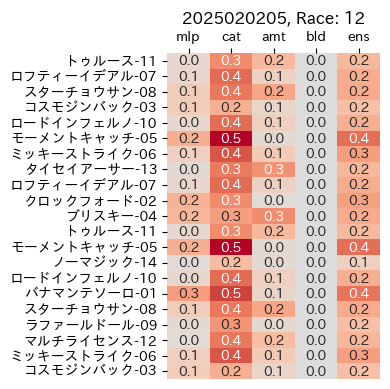

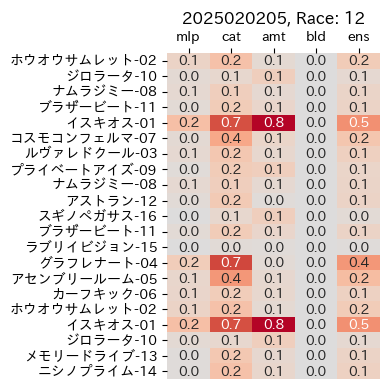

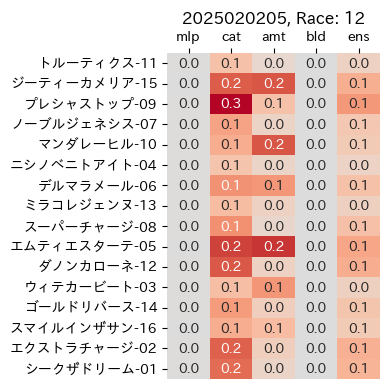

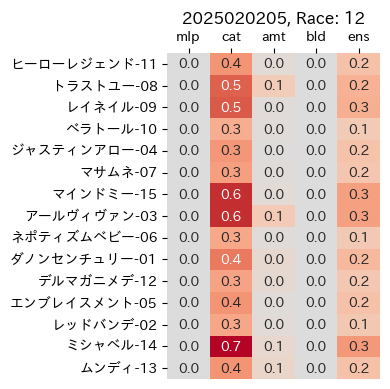

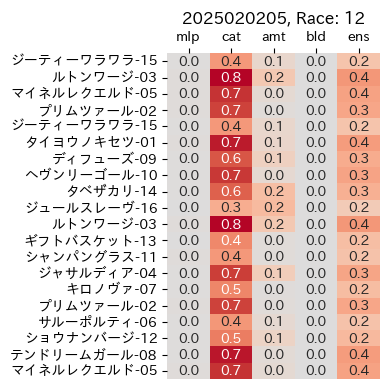

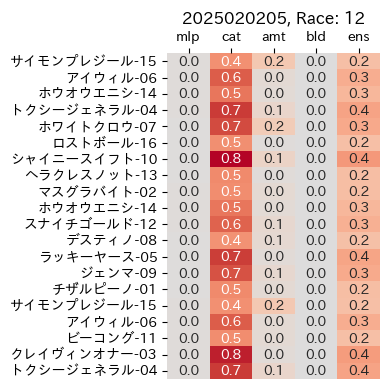

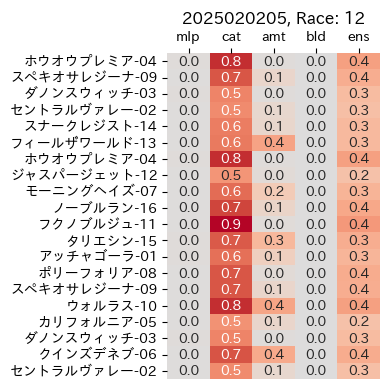

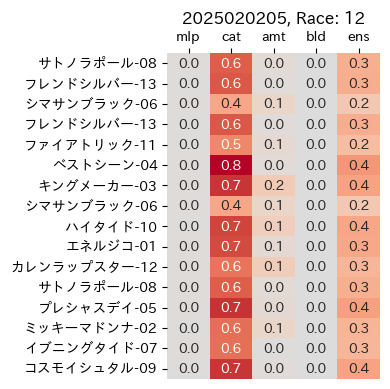

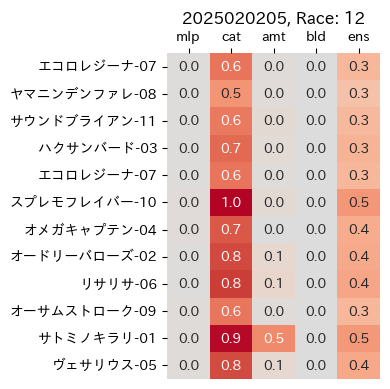

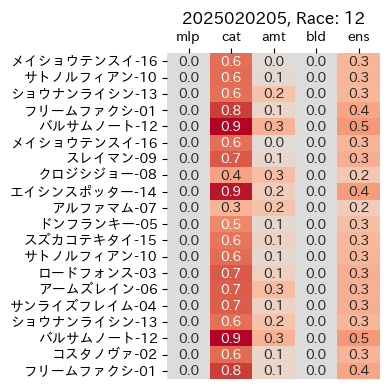

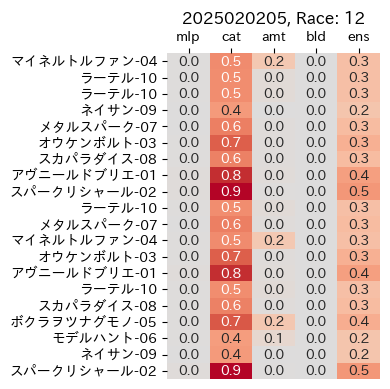

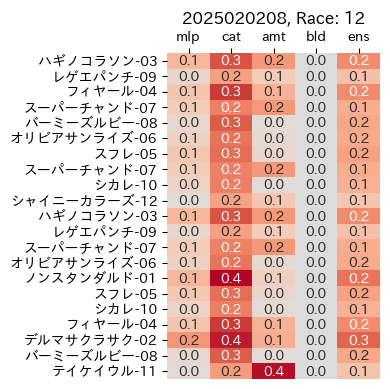

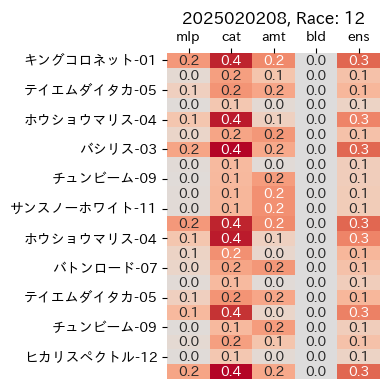

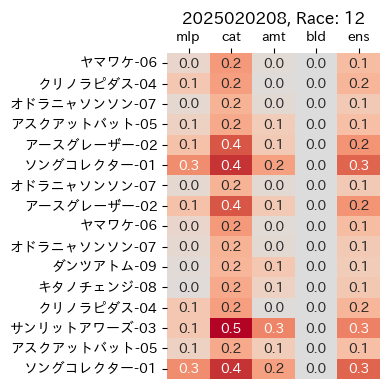

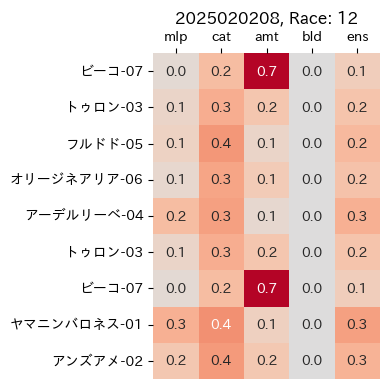

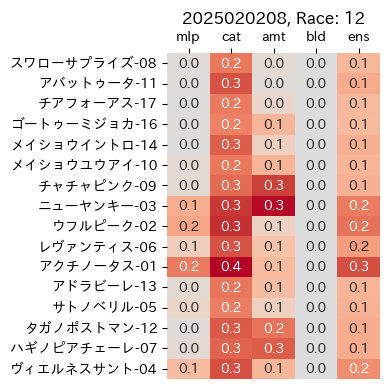

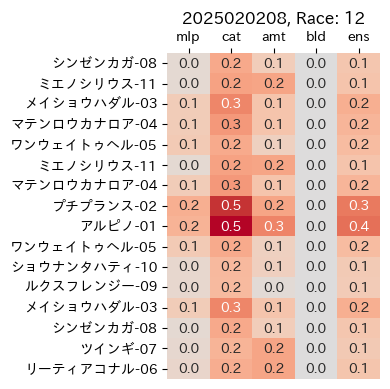

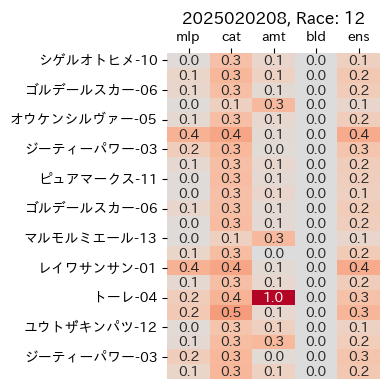

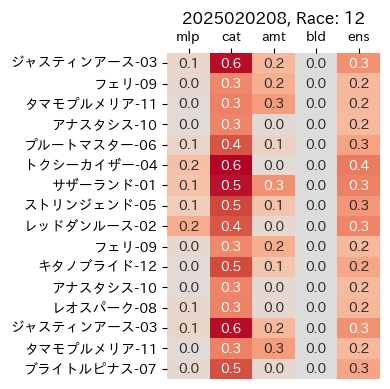

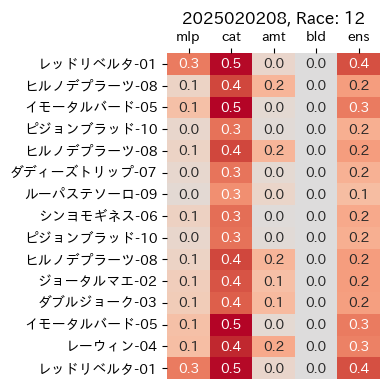

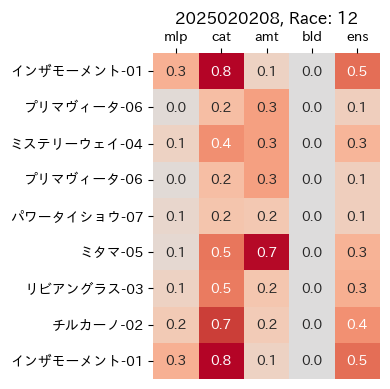

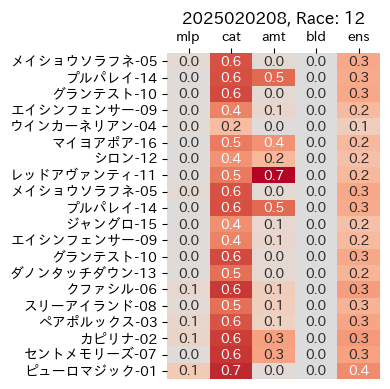

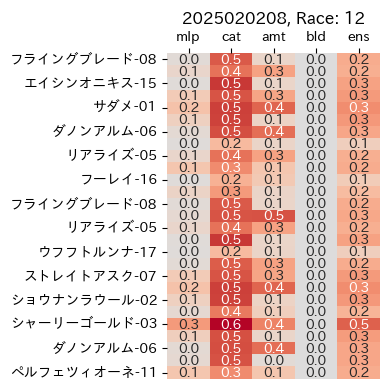

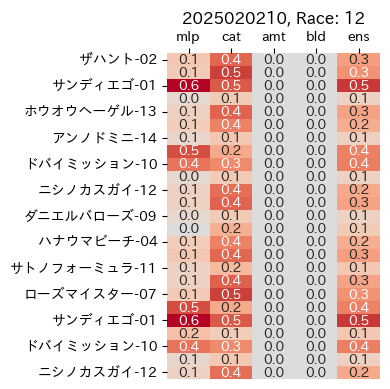

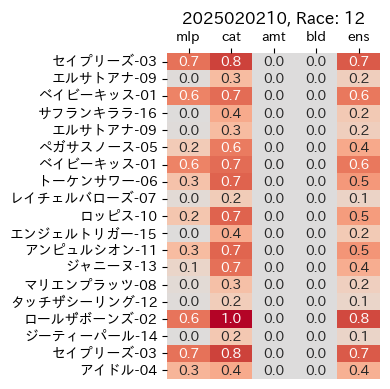

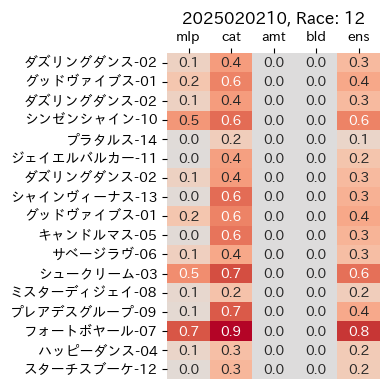

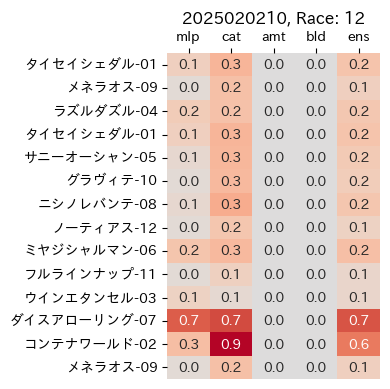

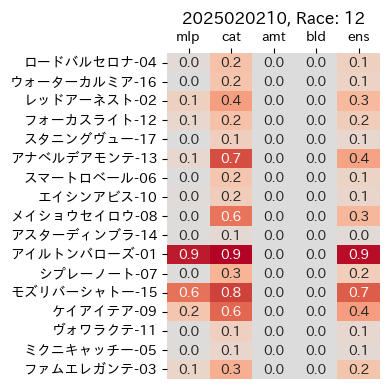

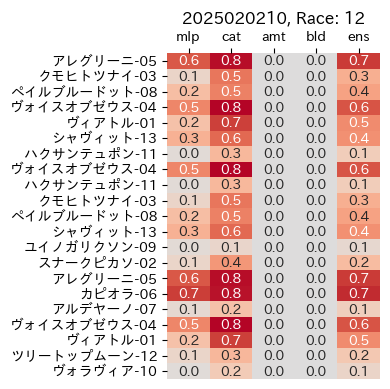

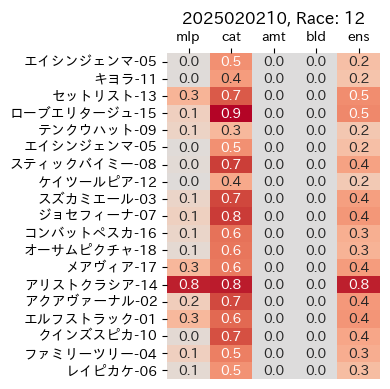

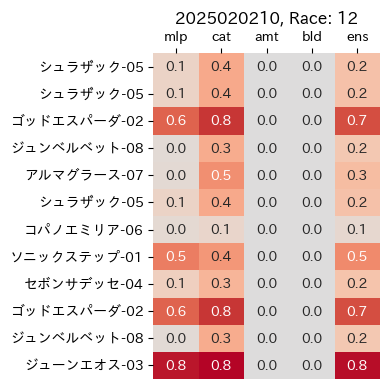

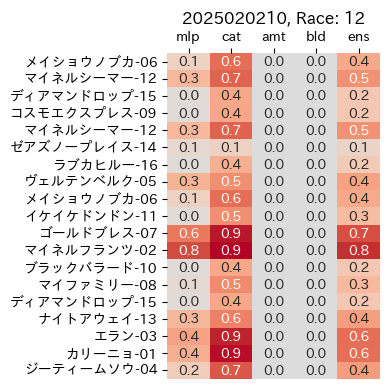

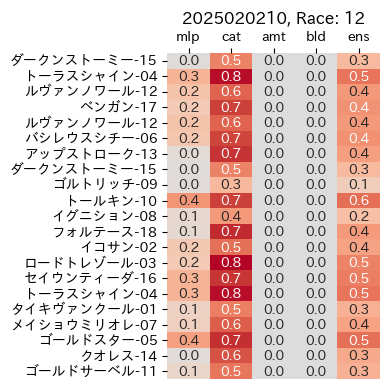

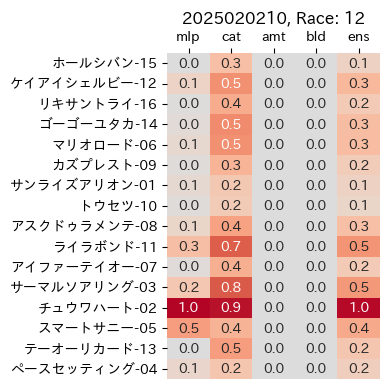

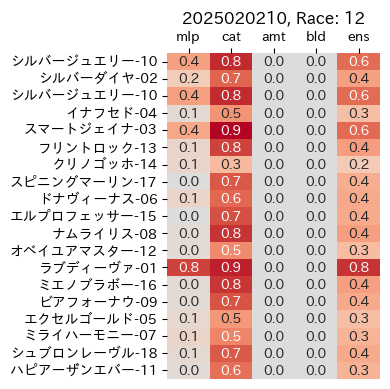

In [90]:


# 表示オプションの設定
pd.set_option('display.max_colwidth', 1)  # 各列の最大表示幅を10に設定

# カスタムカラーマップの作成
colors = [
    (255/255, 255/255, 255/255),  # #FFF2F2 - ほぼ白
    # (255/255, 230/255, 230/255),  # #FFE6E6 - 非常に薄い赤 (90%)
    # (255/255, 217/255, 217/255),  # #FFD9D9 - 非常に薄い赤 (85%)
    (255/255, 204/255, 204/255),  # #FFCCCC - 非常に薄い赤 (80%)
    (255/255, 179/255, 179/255),  # #FFB3B3 - 薄い赤 (70%)
    (255/255, 153/255, 153/255),  # #FF9999 - 薄い赤 (60%)
    (255/255, 128/255, 128/255),  # #FF8080 - 薄い赤 (50%)
    (255/255, 102/255, 102/255),  # #FF6666 - 薄い赤 (40%)
    (255/255, 51/255, 51/255),    # #FF3333 - 薄い赤 (20%)
    (255/255, 0/255, 0/255),      # #FF0000 - 純粋な赤
    (204/255, 0/255, 0/255),      # #CC0000 - 赤
]
custom_cmap = sns.blend_palette(colors, as_cmap=True)
# bt_place、bt_distance、bt_track_cdでグループ化
grouped = df_pr.groupby(['pr_program_id', 'pr_race'])

# 各グループごとにヒートマップを描画
dict_re={}
for (program_id, race_no), group_df in grouped:
    try:
      y = program_id[:4]
      query = f"pr_rank.astype('int') != 0"
      group_df2 = group_df.query(query, engine='python')
      if(len(group_df2)):
        df_re = None
        if( y in  dict_re.keys()):
          df_re = dict_re[y]
        else:
          df_re = query_re_records_by_y(y)
          df_re['rr_r_id'] = df_re['rr_r_id'].astype(str)
          dict_re[y] = df_re


        # pr_rankでソート
        sorted_group_df = group_df2.sort_values(sort_key, ascending = ascending)

        # 'pr_horse_id-pr_vote' の列を作成
        sorted_group_df = pd.merge(df_re, sorted_group_df,
              left_on=['rr_r_horse_id'],
              right_on=['pr_horse_id'],
              how='inner')
        sorted_group_df['pr_horse_id-pr_vote'] = sorted_group_df['rr_r_horse_name'].astype(str) + '-' + sorted_group_df['pr_vote'].astype(str).str.zfill(2)  # 2桁の0詰め

        # ヒートマップのデータ作成
        heatmap_data = sorted_group_df[['pr_horse_id-pr_vote', 'pr_h1_pred', 'pr_h2_pred', 'pr_h3_pred', 'pr_h4_pred', 'pr_hE_pred']]
        heatmap_data = heatmap_data.set_index('pr_horse_id-pr_vote')
        heatmap_data = heatmap_data.rename(columns={
            'pr_h1_pred': 'mlp',
            'pr_h2_pred': 'cat',
            'pr_h3_pred': 'amt',
            'pr_h4_pred': 'bld',
            'pr_hE_pred': 'ens',
        })
        m = program_id[4:6]
        plt.figure(figsize=(4, 4))  # 図のサイズ調整
        ax = sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', center=0, cbar=False)
        ax.xaxis.set_ticks_position('top')     # 目盛りを上部に
        ax.xaxis.set_label_position('top')     # ラベルを上部に
        plt.title(f'{program_id}, Race: {race}')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
    except Exception as e:
      print(e)
